[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PTB-MR/mrpro/blob/main/examples/notebooks/pgd_wavelet_reconstruction.ipynb) [![Download notebook](https://img.shields.io/badge/Download-notebook-blue?logo=jupyter)](path:pgd_wavelet_reconstruction.ipynb)

In [1]:
import importlib

if not importlib.util.find_spec('mrpro'):
    %pip install mrpro[notebooks]

# Accelerated proximal gradient descent (FISTA) reconstruction using wavelets and $\ell_1$-norm minimization

### Image reconstruction
Here, we use a proximal gradient descent algorithm to reconstruct an image
from 2D radial k-space data with wavelet regularization.
In particular, we use the accelerated version known as FISTA (Fast Iterative Shrinkage-Thresholding Algorithm).

Let $y$ denote the k-space data of the image $x_{\mathrm{true}}$ sampled with an acquisition model $A$
(Fourier transform, coil sensitivity maps, etc.), i.e the forward problem is given as

$ y = Ax_{\mathrm{true}} + n, $

where $n$ describes complex Gaussian noise.

As regularization method, here we employ wavelets, which are known to be suitable sparsifying transforms.
We consider the following functional $\mathcal{F}$:

$ \mathcal{F}(x) = \frac{1}{2}||Ax - y||_2^2 + \lambda \| W x \|_1, \quad \quad \quad (1)$

where $W$ is the discretized wavelet operator that maps the image domain to the wavelet domain,
and $\lambda >0$ is an appropriate regularization weight.

The minimization of the functional $\mathcal{F}$ is non-trivial due to
the non-differentiable $\ell_1$-norm and the presence of the wavelet operator.
A possible algorithm to approach the solution of $(1)$ would be the primal dual hybrid gradient (PDHG)
algorithm [[Chambolle \& Pock, JMIV 2011](https://doi.org/10.1007%2Fs10851-010-0251-1)].
However, exploiting the orthonormality of $W$, we can reformulate $(1)$ to solve the minimization problem
in the wavelet domain and use a simpler algorithm. By defining the new variable $\tilde{x} = Wx$
(and thus, due to the orthonormality of $W$, $W^H \tilde{x} = x$), the minimization problem becomes

$ \min_{\tilde{x}} \frac{1}{2}||\tilde{A}\tilde{x} - y||_2^2 + \lambda \| \tilde{x} \|_1,  \quad \quad \quad (2)$

where $\tilde{A}:=A W^H$. A suitable algorithm to solve $(2)$ is the FISTA-algorithm
[[Beck \& Teboulle, SIAM Journal on Imaging Sciences 2009](https://epubs.siam.org/doi/10.1137/080716542)],
which consists of an accelerated proximal gradient descent algorithm.

In general, FISTA can be used to solve problems of the form

$ \min_x f(x) + g(x)  \quad \quad \quad (3)$

where $f$ is a convex, differentiable function with $L$-Lipschitz gradient $\nabla f$,
and $g$ is convex and possibly non-smooth.

The main step of the minimization method is a proximal gradient step, which reads as

$x_{k} = \mathrm{prox}_{\sigma g}(x_{k-1} - \sigma \nabla f({x}_{k-1}))$

where $\mathrm{prox}$ denotes the proximal operator and $\sigma$ is
an appropriate stepsize, ideally $\sigma=\frac{1}{L}$, with $L=L(\nabla f)$ being
the Lipschitz constant of $\nabla f$.

Moreover, FISTA has an additional step to accelerate the convergence. The following variable $z_{k+1}$
is included, consisting of a linear interpolation
of the previous two steps $x_{k}$ and $x_{k-1}$. So, for $t_1=1, z_1=x_0$:

$x_{k} = \mathrm{prox}_{\sigma g}(z_{k} - \sigma \nabla f({z}_{k}))$

$t_{k+1} = \frac{1 + \sqrt{1 + 4t_k^2}}{2}$

$z_{k+1} = x_{k} + \frac{t_k - 1}{t_{k+1}}(x_{k} - x_{k-1}).$

As the Lipschitz constant $L$ is in general not known, and
the interval of the stepsize $\sigma\in ( 0, \frac{1}{|| \tilde{A}||_2^2} )$ is crucial for the convergence,
a backtracking step can  be performed to update the stepsize $\sigma$ at every iteration. To do so,
$\sigma$ is iteratively reduced until reaching a stepsize that is the largest
for which the quadratic approximation of $f$ at $z_{k}$
is an upper bound for $f(x_{k})$.


### Load data
Our example data contains three scans acquired with a 2D golden angle radial trajectory and
varying number of spokes:

- ``radial2D_402spokes_golden_angle_with_traj.h5`` with 402 spokes
- ``radial2D_96spokes_golden_angle_with_traj.h5`` with 96 spokes
- ``radial2D_24spokes_golden_angle_with_traj.h5`` with 24 spokes

We will use the 402 spokes as a reference and try to reconstruct the image from the 24 spokes data.

In [2]:
# ### Download raw data from Zenodo
import tempfile
from pathlib import Path

import zenodo_get

dataset = '14617082'

tmp = tempfile.TemporaryDirectory()  # RAII, automatically cleaned up
data_folder = Path(tmp.name)
zenodo_get.zenodo_get([dataset, '-r', 5, '-o', data_folder])  # r: retries

Title: 2D Radial MR raw data and Pulseq sequences
Keywords: 
Publication date: 2025-01-08
DOI: 10.5281/zenodo.14617082
Total size: 18.7 MB

Link: https://zenodo.org/records/14617082/files/radial2D_24spokes_golden_angle_with_traj.h5   size: 858.7 kB



Checksum is correct. (9a82b5f9c6f27a3db64fd8f7be65cfa3)

Link: https://zenodo.org/records/14617082/files/radial2D_24spokes_golden_angle.seq   size: 29.3 kB



Checksum is correct. (d48ba3340d511a7e24dfc69031a3b6ac)

Link: https://zenodo.org/records/14617082/files/radial2D_402spokes_golden_angle.seq   size: 172.2 kB



Checksum is correct. (ff682e21d7d2434dc5b672523dfeacec)

Link: https://zenodo.org/records/14617082/files/radial2D_96spokes_golden_angle_with_traj.h5   size: 3.4 MB



Checksum is correct. (9fc6d03790b1cf293cbd83939a1dd752)

Link: https://zenodo.org/records/14617082/files/radial2D_402spokes_golden_angle_with_traj.h5   size: 14.2 MB



Checksum is correct. (54d083c0040d3674317006cbaaa95420)

Link: https://zenodo.org/records/14617082/files/radial2D_96spokes_golden_angle.seq   size: 55.9 kB



Checksum is correct. (449434bf7b5e609d09cf5d42cf27c7f3)
All files have been downloaded.


In [3]:
# Load in the data from the ISMRMRD file
import mrpro

# We have embedded the trajectory information in the ISMRMRD files.
kdata_402spokes = mrpro.data.KData.from_file(
    data_folder / 'radial2D_402spokes_golden_angle_with_traj.h5', mrpro.data.traj_calculators.KTrajectoryIsmrmrd()
)
kdata_24spokes = mrpro.data.KData.from_file(
    data_folder / 'radial2D_24spokes_golden_angle_with_traj.h5', mrpro.data.traj_calculators.KTrajectoryIsmrmrd()
)

### Comparison reconstructions
Before running the wavelets-based reconstruction, we first run a direct (adjoint) reconstruction
using `~mrpro.algorithms.reconstruction.DirectReconstruction` (see <project:direct_reconstruction.ipynb>)
of both the 24 spokes and 402 spokes data to have a reference for comparison.

In [4]:
direct_reconstruction_402 = mrpro.algorithms.reconstruction.DirectReconstruction(kdata_402spokes)
direct_reconstruction_24 = mrpro.algorithms.reconstruction.DirectReconstruction(kdata_24spokes)
img_direct_402 = direct_reconstruction_402(kdata_402spokes)
img_direct_24 = direct_reconstruction_24(kdata_24spokes)

We also run an iterative SENSE reconstruction (see <project:iterative_sense_reconstruction_radial2D.ipynb>) with early
stopping of the 24 spokes data. We use it as a comparison and as an initial guess for FISTA.

In [5]:
sense_reconstruction = mrpro.algorithms.reconstruction.IterativeSENSEReconstruction(
    kdata_24spokes,
    n_iterations=8,
    csm=direct_reconstruction_24.csm,
    dcf=direct_reconstruction_24.dcf,
)
img_sense_24 = sense_reconstruction(kdata_24spokes)

### Set up the operator $\tilde{A}$
Define the wavelet operator $W$ and set $\tilde{A} = A W^H = F C W^H $, where $F$ is the Fourier
operator, $C$ denotes the coil sensitivity maps and $W^H$ represents the adjoint wavelet operator.

In [6]:
fourier_operator = direct_reconstruction_24.fourier_op

assert direct_reconstruction_24.csm is not None
csm_operator = direct_reconstruction_24.csm.as_operator()

# Define the wavelet operator
wavelet_operator = mrpro.operators.WaveletOp(
    domain_shape=img_direct_24.data.shape[-2:], dim=(-2, -1), wavelet_name='db4', level=None
)

# Create the full acquisition operator $\tilde{A}$ including the adjoint of the wavelet operator
acquisition_operator = fourier_operator @ csm_operator @ wavelet_operator.H

### Set up the problem
In order to apply FISTA to solve $(2)$, we identify $f$ and $g$ from $(3)$ as

$f(\tilde{x}) = \frac{1}{2}\|\tilde{A}\tilde{x}  - y\|_2^2,$

$g(\tilde{x}) = \lambda \| \tilde{x}\|_1.$

From this, we see that FISTA is a good choice to solve $(2)$,
as $\mathrm{prox}_g$ is given by simple soft-thresholding.

After having run the algorithm for $T$ iterations, the obtained solution $\tilde{x}_{T}$
is in the wavelet domain and needs to be mapped back to image domain.
Thus, we apply the adjoint of the wavelet transform and obtain the solution $x_{\text{opt}}$
in image domain as

$x_{\text{opt}} := W^H \tilde{x}_{T}$.

In [7]:
# Regularization parameter for the $\ell_1$-norm
regularization_parameter = 1e-5

# Set up the problem by using the previously described identification
l2 = 0.5 * mrpro.operators.functionals.L2NormSquared(target=kdata_24spokes.data, divide_by_n=False)
l1 = mrpro.operators.functionals.L1NormViewAsReal(divide_by_n=False)

f = l2 @ acquisition_operator
g = regularization_parameter * l1

In [8]:
# This is a "callback" function to track the value of the objective functional f(x) + g(x)
# and stepsize update
from mrpro.algorithms.optimizers.pgd import PGDStatus


def callback(optimizer_status: PGDStatus) -> None:
    """Print the value of the objective functional every 8th iteration."""
    iteration = optimizer_status['iteration_number']
    solution = optimizer_status['solution']
    if iteration % 8 == 0:
        print(
            f'{iteration}: {optimizer_status["objective"](*solution).item()}, stepsize: {optimizer_status["stepsize"]}'
        )

### Run FISTA for a certain number of iterations
Now we can run the FISTA algorithm to solve the minimization problem. As an initial guess,
we use the wavelet-coefficients of the iterative SENSE image to speed up the convergence.

In [9]:
# compute the stepsize based on the operator norm of the acquisition operator and run FISTA
import torch

# initialize FISTA with adjoint solution
initial_values = wavelet_operator(img_direct_24.data)

op_norm = acquisition_operator.operator_norm(
    initial_value=torch.randn_like(initial_values[0]), dim=(-2, -1), max_iterations=36
).item()

# define step size with a security factor to ensure to
# have stepsize $t \in (0, L(f))$, where $L(f)=1/\|\tilde{A}\|_2^2)$ is
# the Lipschitz constant of the functional $f$
stepsize = 0.9 * (1 / op_norm**2)

(img_wave_pgd_24,) = mrpro.algorithms.optimizers.pgd(
    f=f,
    g=g,
    initial_value=initial_values,
    stepsize=stepsize,
    max_iterations=48,
    backtrack_factor=1.0,
    callback=callback,
)

# map the solution back to image domain
(img_pgd_24,) = wavelet_operator.H(img_wave_pgd_24)

0: 0.00015892248484306037, stepsize: 0.04070599583360028


8: 8.119250560412183e-05, stepsize: 0.04070599583360028


16: 6.130475230747834e-05, stepsize: 0.04070599583360028


24: 6.002188820275478e-05, stepsize: 0.04070599583360028


32: 5.969863195787184e-05, stepsize: 0.04070599583360028


40: 5.9607860748656094e-05, stepsize: 0.04070599583360028


```{note}
When defining the functional $f$ with the argument `divide_b_n=True`, one needs to be careful when setting
the stepsize to be used in FISTA. The reason is that the Lipschitz-constant of the gradient of the functional
$f_N(\tilde{x}) = 1/(2N)\,\|\tilde{A}\tilde{x} - y\|_2^2$, where $y\in\mathbb{C}^N$, is no longer given
by the squared operator norm of $\tilde{A}$, but rather by the squared operator norm of the scaled
operator $1/N \cdot \tilde{A}$. Thus, the Lipschitz constant $L(\nabla f_N)$ must be appropriately scaled,
i.e. $L(\nabla f_N) = N \cdot L( \nabla f)$.
```

## Results
We compare the result of the wavelet regularized reconstruction with the
iterative SENSE and direct reconstruction result.

In [10]:
import matplotlib.pyplot as plt
import torch


def show_images(*images: torch.Tensor, titles: list[str] | None = None) -> None:
    """Plot images."""
    n_images = len(images)
    _, axes = plt.subplots(1, n_images, squeeze=False, figsize=(n_images * 3, 3))
    for i in range(n_images):
        axes[0][i].imshow(images[i], cmap='gray', clim=[0, 3e-4])
        axes[0][i].axis('off')
        if titles:
            axes[0][i].set_title(titles[i])
    plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


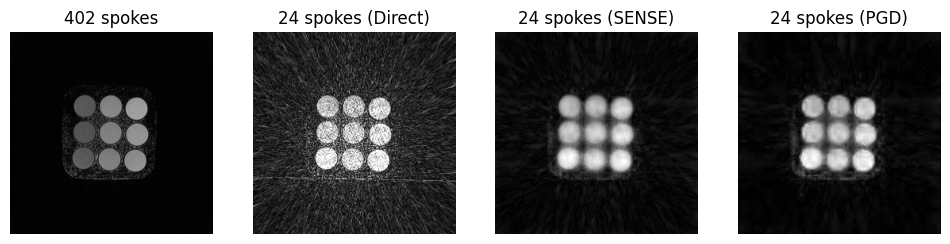

In [11]:
# see the collapsed cell above for the implementation of show_images
show_images(
    img_direct_402.rss().squeeze(),
    img_direct_24.rss().squeeze(),
    img_sense_24.rss().squeeze(),
    img_pgd_24.abs().squeeze(),
    titles=['402 spokes', '24 spokes (Direct)', '24 spokes (SENSE)', '24 spokes (PGD)'],
)

Congratulations! We have successfully reconstructed an image from 24 spokes using wavelets.

### Next steps
Not happy with the results? Play around with the regularization weight, the number of iterations, the
number of levels in the wavelet decomposition or the backtracking factor to see how they affect the final image.
Still not happy? Maybe worth giving a try to total variation (TV)-minimization as an alternative
regularization method (see <project:tv_minimization_reconstruction_pdhg.ipynb>).
You can also try to use the 96 spokes data to see how the reconstruction quality improves with more spokes.